# Assignment 1 (part II): Automatic Panorama Mosaicing

In [174]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray
from skimage.measure import ransac
from skimage import transform as tf

### The cell below demonstrates feature detection (e.g. corners) and matching (e.g. BRIEF descriptor) 

the number of matches is 53


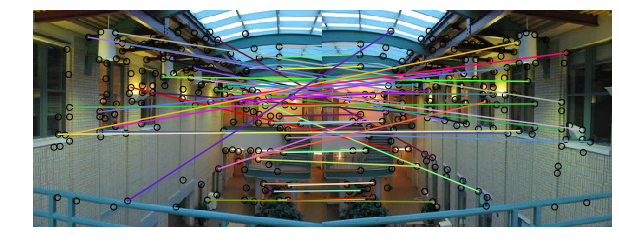

In [175]:
imL = image.imread("images/CMU_left.jpg")
imR = image.imread("images/CMU_right.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.0005, min_distance=5)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.0005, min_distance=5)

extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

## Problem 1
### Rederive your formula in Problem 3a from Part I of the assignment for the following modification. Assume there are $N=53$ matches $(p,p')$ as in figure 1 above. $N_i=21$ of these matches are inliers for a homography, while the rest of the matches are $N_o=32$ outliers. To estimate a homography you need a sample with $K=4$ matches. What is the least number of times one should randomly sample a subset of $K$ matches to get probability  $p≥0.95$  that at least one of these samples has all of its $K$ matches from inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution:

Similar wiht the Porblem 3a, let assume i is the probability that the chosen points is the inlier. Since we want sample wiht size K, $i^K$ will be the probability that all K points are the inlier. Futhermore, $1-i^K$ will then be the probability that one or more points chosen for a sample of K points are outliers. Rise that to C, $(1-i^K)^C$ will then be the probability that C chosen samples (the chosen K points) contains one or more points that are outliers. We negate that, $1-(1-i^K)^C$ will then gived us the probability of C chosen samples contains at least one sample (all K chosen points) that are inliers which is the p we want! With the above situation, $0.95=1-(1-\frac{21}{53}^4)^C$ and we can solve for C for the sample size needed which is $120.03872067$ so rougth 121 sample needed.

## Problem 2: (RANSAC for Homographies)
### Write code below using RANSAC to estimate Homography from matched pairs of points above. This cell should display new figure 2 similar to figure 1 above, but it should show only inlier pairs for the detected homography. HINT: you can use $ProjectiveTransform$  from library $skimage$ declared at the top of the notebok.

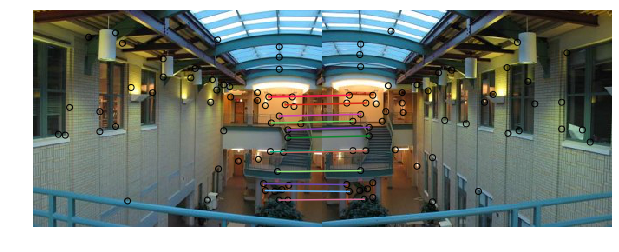

In [176]:
# compose the matching pair data for the ransac function
src = np.zeros((matchesLR.shape[0], 2))
dst = np.zeros((matchesLR.shape[0], 2))
for i in range(matchesLR.shape[0]):
    src[i] = keypointsL[matchesLR[i][0]]
    dst[i] = keypointsR[matchesLR[i][1]]
    # swap the row and col for the convention of ransac function
    row = src[i][0]
    src[i][0] = src[i][1]
    src[i][1] = row
    col = dst[i][1]
    dst[i][1] = dst[i][0]
    dst[i][0] = col

# Perform RANSAC with 121 iteration
tform = tf.ProjectiveTransform()
model, inliers = ransac((dst,src), ProjectiveTransform, min_samples=4, residual_threshold=1,  max_trials=121)

# Count the number of inliers
count = 0
for k in range(inliers.shape[0]):
    if (inliers[k] == True):
        count = count+1

# Get the inliers index
c_inliers = np.zeros((count,2))
count = 0
for j in range(inliers.shape[0]):
    if (inliers[j] == True):
        c_inliers[count][0] = int(j)
        c_inliers[count][1] = int(j)
        count  = count+1
        
# Swap the coordinate back for plotting
for l in range(matchesLR.shape[0]): 
    row = src[l][0]
    src[l][0] = src[l][1]
    src[l][1] = row
    col = dst[l][1]
    dst[l][1] = dst[l][0]
    dst[l][0] = col
    
fig = plt.figure(2,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, src, dst, c_inliers.astype(int)) #, matches_color = 'r')
axA.axis('off')

plt.show()

## Problem 3 (reprojecting onto common PP)
### Use common PP corresponding to the plane of the left image. Your pamorama mosaic should be build inside a "reference frame" (think about it as an empty canvas of certain size) inside this common PP. The reference frame should be big enough to contain the left image and the part of the view covered by the right image after reprojecting onto common PP. Create a new figure 3 including the following three images (spread them vertically). First, show your reference frame only with the left image inside. Second, show the reference frame containing only a reprojected right image (warp it using a homography computed in Problem 1). Third, for comparison, show the reference frame containing only the right image reprojected using a (bad) homography estimated from all matches (including outliers, as in figure 1).
#### HINT1: use function $warp$ from library $skimage$ declared at the top of the notebook. 
#### HINT2: function $warp$ needs "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities

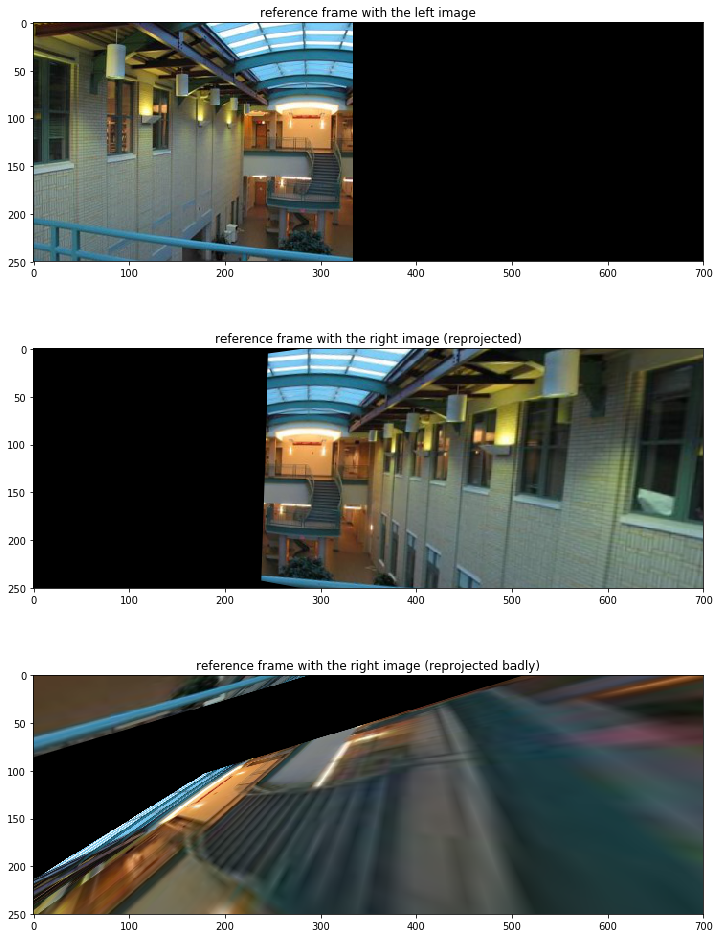

In [321]:
fig = plt.figure(3,figsize = (12, 17))
plt.subplot(311)
# Warped the left image with the empty homography to match the size of the image
tform2 = tf.ProjectiveTransform()
warpedL = tf.warp(imL,tform2.inverse,output_shape=(250, 700))
plt.imshow(warpedL)
plt.title("reference frame with the left image")

plt.subplot(312)
# Warped the right image wiht the derived homography
warped = tf.warp(imR,model.inverse,output_shape=(250, 700))
plt.imshow(warped)
plt.title("reference frame with the right image (reprojected)")
  
# Swap the coordinate for estimate function convention
for m in range(matchesLR.shape[0]): 
    row = src[m][0]
    src[m][0] = src[m][1]
    src[m][1] = row
    col = dst[m][1]
    dst[m][1] = dst[m][0]
    dst[m][0] = col
    
# Calculate the homography using projectiveTransform and all the points from Problem1
tform.estimate(src,dst)

plt.subplot(313)
# Warped hte right image with the homography estimated with all the pints from Problem1
warped2 = tf.warp(imR,tform.inverse,output_shape=(250, 700))
plt.imshow(warped2)
plt.title("reference frame with the right image (reprojected badly)")

plt.show()

## Problem 4 (blending)

### (part a) Write code for a function below computing distance transform for the boundary of a given image. It returns a numpy array of the same size as the image with distances from each pixel to the closest point on the boundary of the image (float values). 
   

In [322]:
from skimage.color import rgb2gray
from copy import deepcopy

def boundaryDT(image):
    img = deepcopy(rgb2gray(image))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i,j] = (i+0.5)
            if (img[i,j] > (j+0.5)):
                img[i,j] = (j+0.5)
                
    return img

### (part b) Use function from part (a) to compute a distance transform for both images. Create a new figure 4 showing the following two images. First, show reference frame containing only the left image's boundaryDT instead of the left image. Second, show reference frame containing only the right image's boundaryDT reprojected instead of the right image. 

Text(0.5, 1.0, 'Right image DT in Ref. frame (RdtRef)')

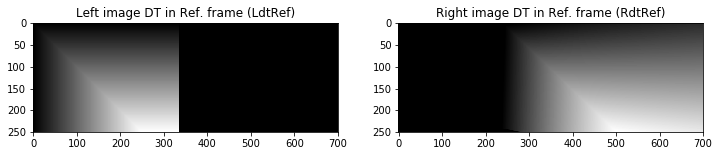

In [323]:
fig = plt.figure(4,figsize = (12, 3))
plt.subplot(121)
# the distance transform of left image
warpedL2 = tf.warp(boundaryDT(imL),tform2.inverse,output_shape=(250, 700))
plt.imshow(warpedL2)
plt.title("Left image DT in Ref. frame (LdtRef)")

plt.subplot(122)
# warped distance transfromed for right image
warped3 = tf.warp(boundaryDT(warped),model.inverse,output_shape=(250, 700))
plt.imshow(warped3)
plt.title("Right image DT in Ref. frame (RdtRef)")

### (part c) Use boundary distance transforms to blend left and right images (reprojected) into the reference frame. Create a new figure 5 showing the following three images. First and second should be $alpha$'s for blending the left and right images. These alphas should be based on distance transforms as discussed in class. Third, should be your panorama: left and (reprojected) right images blended inside the reference frame. Your panorama should also show (reprojected) features - homography inliers - from both left and right images. Use different colors/shapes to distinct features from the left and the right images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


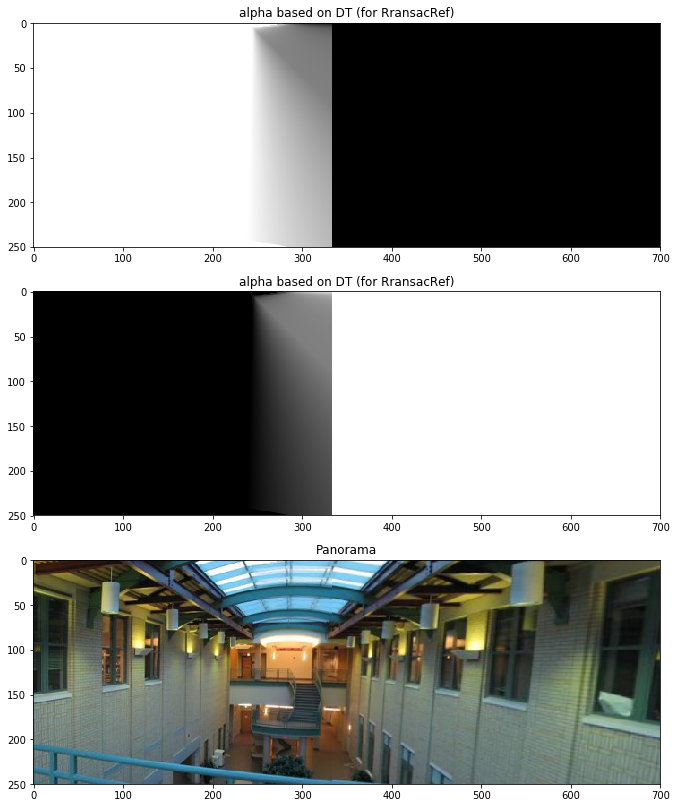

In [324]:
# Calculate the alpha for imgL)
alpha1 = warpedL2/(warpedL2+warped3)

fig = plt.figure(5,figsize = (12, 14))
plt.subplot(311)
plt.imshow(alpha1)
plt.title("alpha based on DT (for RransacRef)")

# Calulate the alpha for imgR
alpha2 = warped3/(warpedL2+warped3)
plt.subplot(312)
plt.imshow(alpha2)
plt.title("alpha based on DT (for RransacRef)")

# update both image with alpha
for i in range(warpedL.shape[0]):
    for j in range(warpedL.shape[1]):
        warpedL[i][j][0] = warpedL[i][j][0]*alpha1[i][j]
        warpedL[i][j][1] = warpedL[i][j][1]*alpha1[i][j]
        warpedL[i][j][2] = warpedL[i][j][2]*alpha1[i][j]
        warped[i][j][0] = warped[i][j][0]*alpha2[i][j]
        warped[i][j][1] = warped[i][j][1]*alpha2[i][j]
        warped[i][j][2] = warped[i][j][2]*alpha2[i][j]


plt.subplot(313)
# combine both image
imgwhole=(warpedL+warped)
plt.imshow(imgwhole)
plt.title("Panorama")
plt.show()